## Run, Don't Read

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import argparse
import os 
import sys
import numpy as np
import torch
import gc
import copy
import pandas as pd
import copy
import gc

from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaTokenizer
from collections import defaultdict

print('# of gpus: ', torch.cuda.device_count())

import json
import logging
import math

import accelerate
import bitsandbytes

import random
from itertools import chain
from pathlib import Path

import datasets

from accelerate import Accelerator, DistributedType
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from datasets import load_dataset
from huggingface_hub import Repository, create_repo
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import transformers
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AutoConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    GPT2Tokenizer,
    GPT2Config,
    GPT2Model,
    BitsAndBytesConfig
)
from transformers.utils import check_min_version, get_full_repo_name, send_example_telemetry
from transformers.utils.versions import require_version
from importlib.metadata import version

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow

from utils.utils import *
from utils.PatchingMetric import ave_logit_diff
from utils.eval_circuit import *
from utils.Visualization import outline_IoU, outline_IOI, heat_map_sparsity

from Pruning.FLAP.lib.prune import prune_wanda_sp, prune_flap, prune_magnitude_sp, check_sparsity
from Pruning.FLAP.lib.eval import eval_ppl

from Pruning.FLAP.models.hf_llama.modeling_llama import LlamaForCausalLM
from Pruning.FLAP.models.hf_gpt.modeling_gpt2 import load_pretrained_llama_style_gpt2


is_notebook = get_ipython()
ipython =  is_notebook is not None

from logger_config import logger

# of gpus:  2


In [9]:
def get_Llama(model:str, cache_dir:str="llm_weights", device:str="cuda", use_4bit:bool=False):
    """Get Llama model from huggingface hub. Also set biases to zero for self_attn.o_proj and mlp.down_proj.
    
    Args:
        model (str): model name
        cache_dir (str, optional): Path to cached weights.. Defaults to "llm_weights".
        device (str, optional): Device. Defaults to "cuda".

    Returns:
        LlamaForCausalLM: Llama model
    """
    
    if device == "cpu":
        dtype=torch.float32
        device_map="cpu"
    else:
        dtype=torch.float16
        device_map="auto"
    
   
    model = LlamaForCausalLM.from_pretrained(
        model, 
        torch_dtype=dtype, 
        cache_dir=cache_dir, 
        low_cpu_mem_usage=True, 
        device_map=device_map,
        load_in_4bit=use_4bit
       )
    
    for i in range(32):
        model.model.layers[i].self_attn.o_proj.bias = torch.nn.Parameter(torch.zeros_like(model.model.layers[i].self_attn.o_proj.bias, device=device))  # 或 'cuda'
        #model.model.layers[i].mlp.down_proj.bias = torch.nn.Parameter(torch.zeros_like(model.model.layers[i].mlp.down_proj.bias, device='cpu'))  # 或 'cuda'
        torch.nn.init.zeros_(model.model.layers[i].self_attn.o_proj.bias)
        #torch.nn.init.zeros_(model.model.layers[i].mlp.down_proj.bias)
        
    model.seqlen = 22
    return model

def get_gpt2(model:str, cache_dir:str="llm_weights", device:str="cpu"):
    """Get the original GPT2 model from Hugging Face.

    Args:
        model (str): model name
        cache_dir (str, optional): Path to cached weights. Defaults to "llm_weights".
        device (str, optional): Device. Defaults to "cpu".

    Returns:
        AutoModelForCausalLM: gpt2 model
    """
    
    if device == "cpu":
        dtype=torch.float32
    else:
        dtype=torch.float16
    
    cache_dir =os.path.abspath("../../../../../../" + cache_dir)
    print("cache_dir: ", cache_dir)
    os.makedirs(cache_dir, exist_ok=True)

    model = AutoModelForCausalLM.from_pretrained(
        model, 
        torch_dtype=dtype,
        cache_dir=cache_dir, 
        low_cpu_mem_usage=True, 
        device_map=device
    )

    model.seqlen = 22
    return model

def get_gpt2_adapt(model:str, device:str="cpu"):
    """Get the GPT2 model from hugging face and adapt it to Llama style:
        - structure transformer.h -> model.layers
        - attn -> self_attn
        - c_attn split into q_proj, k_proj, v_proj, c_proj -> o_proj

    Args:
        model (str): model name
        device (str, optional): Device. Defaults to "cpu".

    Returns:
        GPT2LMHeadModel2Llama: GPT2 model adapted to Llama style
    """
    if device == "cpu":
        dtype=torch.float32
    else:
        dtype=torch.float16
    model =  load_pretrained_llama_style_gpt2(model)
    
    model.seqlen=22
    model.config.intermediate_size = model.config.n_embd
    model.config.num_attention_heads = model.config.n_head
    """
    for i in range(12):
        model.model.layers[i].self_attn.o_proj.bias = torch.nn.Parameter(torch.zeros_like(model.model.layers[i].self_attn.o_proj.bias, device='cpu'))  # 或 'cuda'
        torch.nn.init.zeros_(model.model.layers[i].self_attn.o_proj.bias)
    """ 
    
    model.eval()
    return model

from transformer_lens import utils, HookedTransformer, ActivationCache

def get_hooked_llm(model, device):
    model= HookedTransformer.from_pretrained(
        model_name=model,
        center_unembed=False,                    # set mean of every output vector W_U to zero
        center_writing_weights=False,            # normalize all input writing to residual stream
        fold_ln=False,                           # regularisation method: Hooked Transformer handels centering & normalization & linear operations all together, factor out te linear part
                                                # almost linear map: variance scalling divides by norm of vector -> norm not linear
        refactor_factored_attn_matrices=False,   # use low-rank matrices W_OV, W_QK instead of W_O and W_V (W_Q and W_K)
        torch_dtype=torch.float32,
        low_cpu_mem_usage=True,
        )
    #model.set_use_hook_mlp_in(True)        
    model = model.to(device)   
    model.seqlen = 22
    model.set_use_attn_result(True)
    model.set_use_split_qkv_input(True)

    return model


## Main

In [12]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, help='LLaMA model')    # Huggingface model name
parser.add_argument('--seed', type=int, default=0, help='Seed for sampling the calibration data.')
parser.add_argument('--nsamples', type=int, default=2048, help='Number of calibration samples.')
parser.add_argument('--pruning_ratio', type=float, default=0, help='Pruning ratio.')
parser.add_argument('--remove_heads', type=int, default=8, help='Remove num_heads')
parser.add_argument("--metrics", type=str, default="WIFV", choices=["IFV", "WIFV", "WIFN", 'N/A', "WIFVB"])
parser.add_argument("--structure", type=str, default="AL-AM", choices=["UL-UM", "UL-MM", "AL-MM", "AL-AM", 'N/A'])
parser.add_argument("--prune_method", type=str, default="flap", choices=["flap", "wanda_sp", "mag_sp"])
parser.add_argument("--cache_dir", default="llm_weights", type=str)
parser.add_argument('--unstr', action="store_true")
parser.add_argument('--eval', action="store_true")
parser.add_argument('--save_model', type=str, default=None, help='Path to save the pruned model.')

"""
METRICS:
1) WIFN: Weighted Input Feature Norm: 
    - assess the effect of weights columns on output feature map (like WANDA and OWL)
2) IFV: Input Feature Variance
    - Variability among features
    - sample variance of each input feature
3) WIFV: Weights Input Feature Variance 
    - used by FLAP
    - influence of an column of the weight matrix on the recovery of the output feature map
    - "Fluctuation metric"
    - sample variance of each input feature weightes with the squared norm of the corresponding weight matrix column

STRUCUTRE
adaptively search the global compression model structures
magnited of metrics vary within different layers

    - UL-UM: Uniform across Layers and Modules 
        - all layers/modules share the same sparsity ratio like in WANDA
    - UL-MM: Uniform across Layer, Manual ratio for Modules
    - AL-MM: Adaptive across Layers, Manuel ratio for Modules
        - amount of attention heads to removed manually set via --remove_heads
        - MLP pruning is done via pruning ratio GLOBALLY over ALL modules (attention-layers, mlp)
    - AL-AM: Adaptive Across both Layers and Modules
        - MLP and attention layer pruning is done via pruning ratio GLOBALLY over ALL modules (attention-layers, mlp)


Layers = pruned via attention heads
Modules = FeedForward block, mlp
Uniform: all share the same sparsity value
manual: using the --remove_heads parameter to remove a specific amount of heads
adaptive:
    - standardize meatric distribution across layers to equal mean and std
    - capture the absolute variation in the output feature map, when input features are replaced with their baseline values

"""

############ New Parser Arguments ##############################
parser.add_argument("--use_mlp", action="store_true", help="prune MLPs")
parser.add_argument("--task", type=str, default="wikitext2", help="dataset to run pruning on")
parser.add_argument("--device", type=str, default="cpu", help="device to run pruning on")
parser.add_argument("--use_4bit", action="store_true", help="use 4bit quantization")

if ipython:
    input_args = [
        #'--model=baffo32/decapoda-research-llama-7B-hf',
        '--model=gpt2',
        '--seed=239501',
        '--nsamples=50',  
        #'--pruning_ratio=0.8',
        '--metrics=WIFV', 
        '--structure=AL-MM',
        '--cache_dir=/mnt/qb/work/eickhoff/esx670/llm_weights',
        '--remove_heads=129', # 144 - 129 = 215 -> keep 20 heads ~ IOI Circuit size
        '--eval',
        '--task=ioi_all',
        '--device=cpu',
    ]


args = parser.parse_args(input_args)

# Setting seeds for reproducibility
np.random.seed(args.seed)
torch.random.manual_seed(args.seed)

In [16]:
# stuff to run evaluations on

gpt2_model = get_gpt2("gpt2", device="cpu", cache_dir=args.cache_dir)
gpt2_model.eval()

model_mean_ablation = get_hooked_llm(args.model, device="cpu")  
model_mean_ablation.eval()

tokenizer = AutoTokenizer.from_pretrained("gpt2", force_download=False, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
                
dataset = load_dataset(prepend_bos=False, task="ioi", patching_method="path",tokenizer=tokenizer, N=40, device=args.device)

# original gpt2 model
logits_gt = gpt2_model(dataset.clean_tokens).logits
ave_logit_gt = ave_logit_diff(logits_gt, dataset.answer_tokens.to(args.device), dataset.target_idx.to(args.device))
print("Average logit difference original model: ", ave_logit_gt)

# IOI circuit
IOI_CIRCUIT = {
    11: [10],
    10: [0, 7], 
    9:  [9, 6],
    8:  [6, 10],
    7:  [3, 9],
    6:  [9],
    5:  [5],    
    4:  [11],
    3:  [0],
    2:  [2], 
    0:  [1]
}

ave_logit_IOI, performance_IOI = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=IOI_CIRCUIT,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

print_statics(
    title="*********** IOI CIRCUIT WITHOUT BACKUP HEADS**************",
    ave_logit=ave_logit_IOI, 
    performance_achieved=performance_IOI,
    CIRCUIT=IOI_CIRCUIT, 
    IOI_CIRCUIT=IOI_CIRCUIT
    )


cache_dir:  /mnt/qb/work/eickhoff/esx670/llm_weights


/mnt/lustre/work/eickhoff/esx670/.conda/py-311-pytorch_clone1/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
device cpu
Average logit difference original model:  3.0309038162231445
*********** IOI CIRCUIT WITHOUT BACKUP HEADS**************
Average logit difference (IOI dataset, ): 2.0933
circuit size 15
performance achieved 69.07%
IoU of IOI and CIRCUIT  100.00%



loading calibdation data
using different length!
dataset loading complete


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:48<00:00,  4.04s/it]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 1.7369
circuit size 15
performance achieved 57.31%
IoU of IOI and CIRCUIT  66.67%
performance gain -17.03%



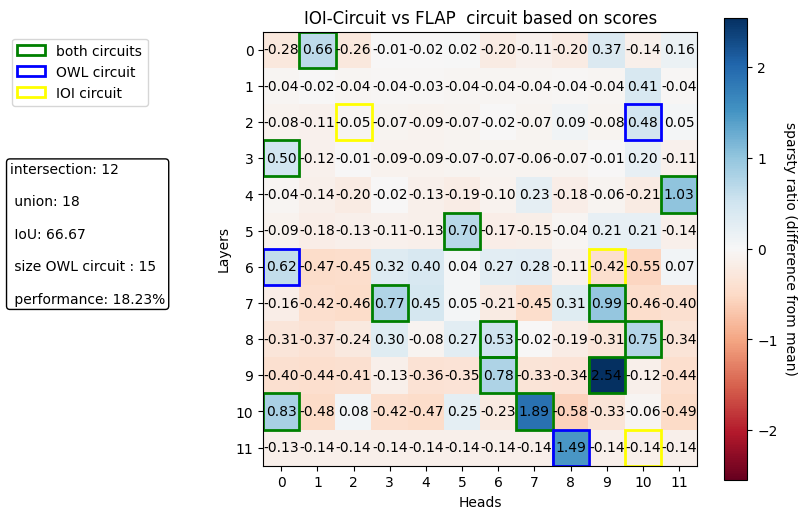

*********** REMOVE head (0, 1) **************
Average logit difference (IOI dataset, FLAP-REMOVED): 1.0079
circuit size 14
performance achieved 33.25%
IoU of IOI and CIRCUIT  61.11%
performance gain -41.97%



/tmp/ipykernel_3762609/2536933395.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_col], ignore_index=True)


*********** REMOVE head (2, 10) **************
Average logit difference (IOI dataset, FLAP-REMOVED): 1.7314
circuit size 14
performance achieved 57.13%
IoU of IOI and CIRCUIT  70.59%
performance gain -0.32%

*********** REMOVE head (3, 0) **************
Average logit difference (IOI dataset, FLAP-REMOVED): 1.3360
circuit size 14
performance achieved 44.08%
IoU of IOI and CIRCUIT  61.11%
performance gain -23.08%

*********** REMOVE head (4, 11) **************
Average logit difference (IOI dataset, FLAP-REMOVED): 1.0470
circuit size 14
performance achieved 34.54%
IoU of IOI and CIRCUIT  61.11%
performance gain -39.72%

*********** REMOVE head (5, 5) **************
Average logit difference (IOI dataset, FLAP-REMOVED): 0.8849
circuit size 14
performance achieved 29.20%
IoU of IOI and CIRCUIT  61.11%
performance gain -49.05%

*********** REMOVE head (6, 0) **************
Average logit difference (IOI dataset, FLAP-REMOVED): 1.6817
circuit size 14
performance achieved 55.48%
IoU of IOI and C

/mnt/lustre/work/eickhoff/esx670/.conda/py-311-pytorch_clone1/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


loading calibdation data
using different length!
dataset loading complete


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.10it/s]


512
*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



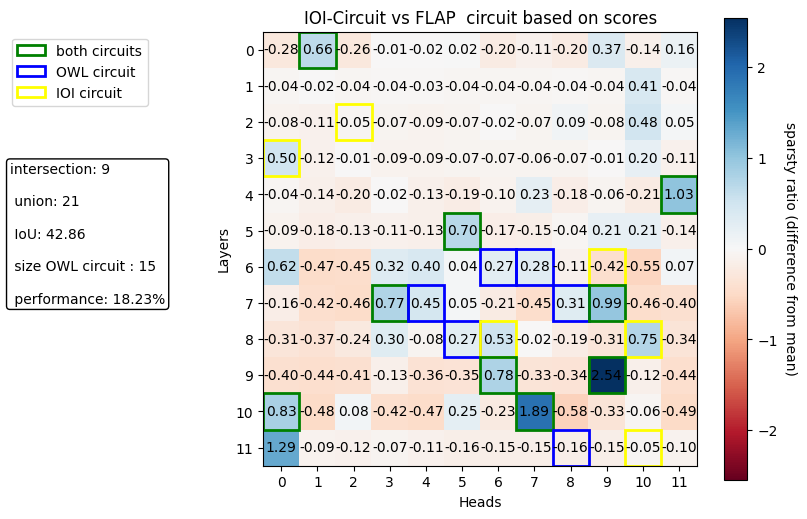

new_head {6: [6, 7], 7: [8, 4], 8: [5], 11: [8]}
outlier heads [(11, 8), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  5.96it/s]

384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.89it/s]


512
*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



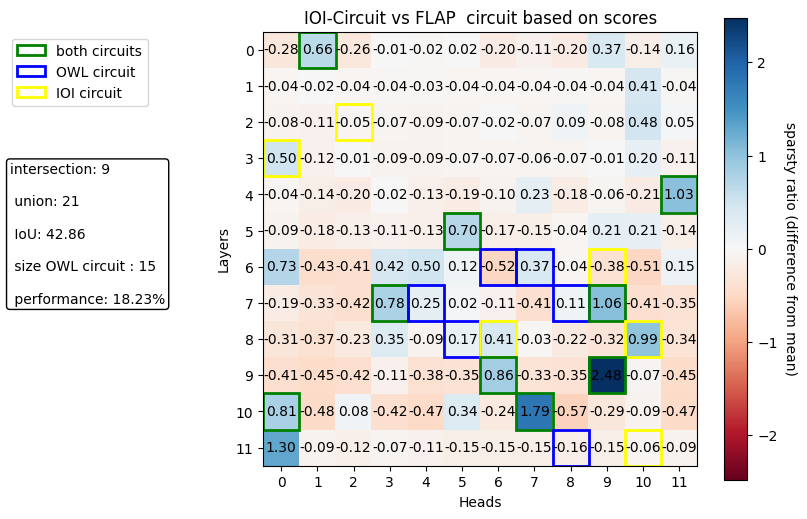

new_head {6: [6, 7], 7: [8, 4], 8: [5], 11: [8]}
outlier heads [(11, 8), (6, 6), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  5.96it/s]

384
384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.85it/s]


512
*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



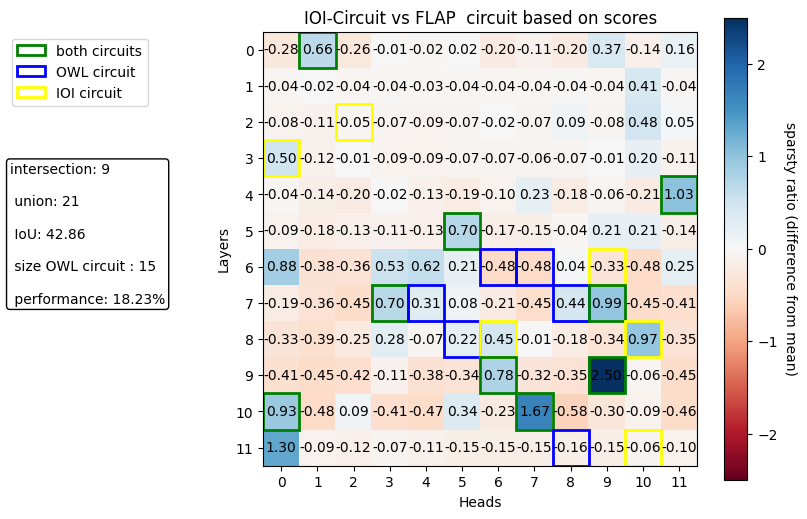

new_head {6: [6, 7], 7: [8, 4], 8: [5], 11: [8]}
outlier heads [(2, 10)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  33%|████████████████████████████████████████████▋                                                                                         | 4/12 [00:00<00:01,  5.88it/s]

640


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.83it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



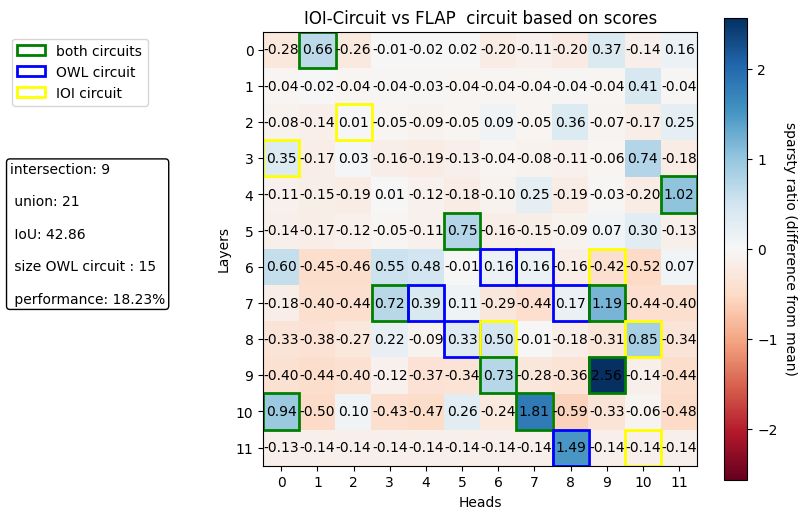

new_head {6: [6, 7], 7: [8, 4], 8: [5]}
outlier heads [(2, 10), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  33%|████████████████████████████████████████████▋                                                                                         | 4/12 [00:00<00:01,  6.04it/s]

640


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  6.10it/s]

384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.96it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



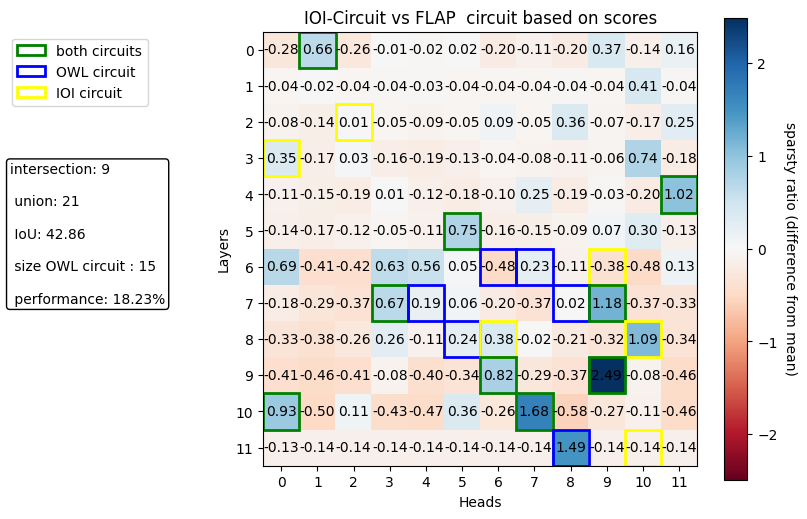

new_head {6: [6, 7], 7: [8, 4], 8: [5]}
outlier heads [(2, 10), (6, 6), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  33%|████████████████████████████████████████████▋                                                                                         | 4/12 [00:00<00:01,  6.06it/s]

640


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  6.08it/s]

384
384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.94it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



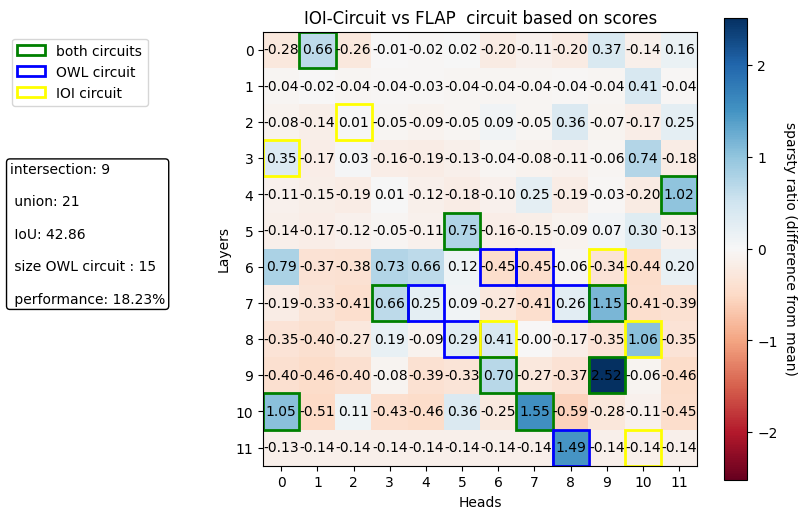

new_head {6: [6, 7], 7: [8, 4], 8: [5]}
outlier heads [(9, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 11/12 [00:01<00:00,  6.27it/s]

384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.16it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



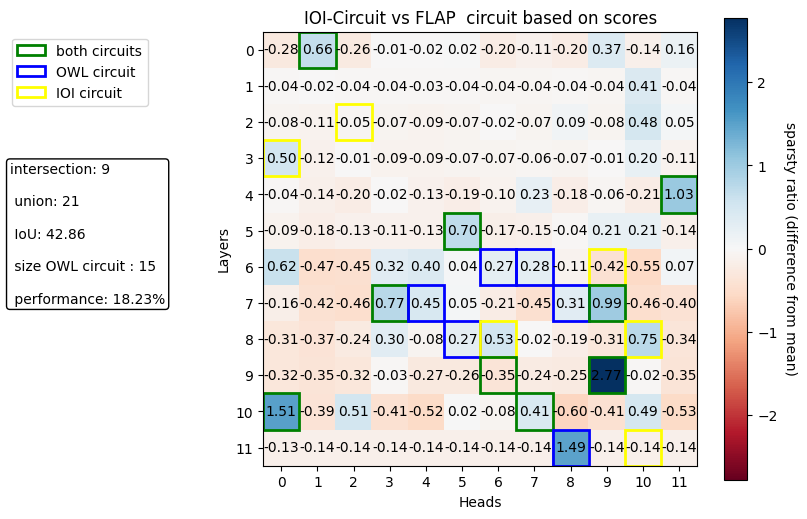

new_head {6: [6, 7], 7: [8, 4], 8: [5], 9: [6], 10: [7]}
outlier heads [(9, 6), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  5.94it/s]

384


Processing layers:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 11/12 [00:01<00:00,  5.70it/s]

384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.78it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



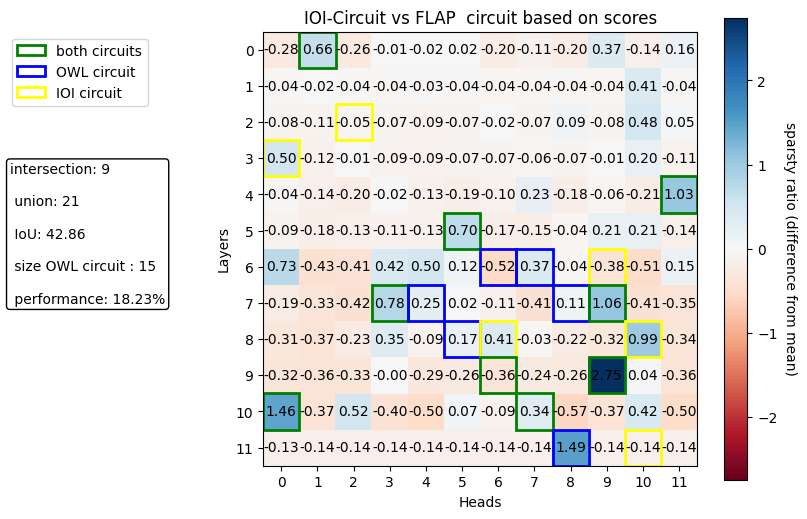

new_head {6: [6, 7], 7: [8, 4], 8: [5], 9: [6], 10: [7]}
outlier heads [(9, 6), (6, 6), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  6.03it/s]

384
384


Processing layers:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 11/12 [00:01<00:00,  5.71it/s]

384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.80it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



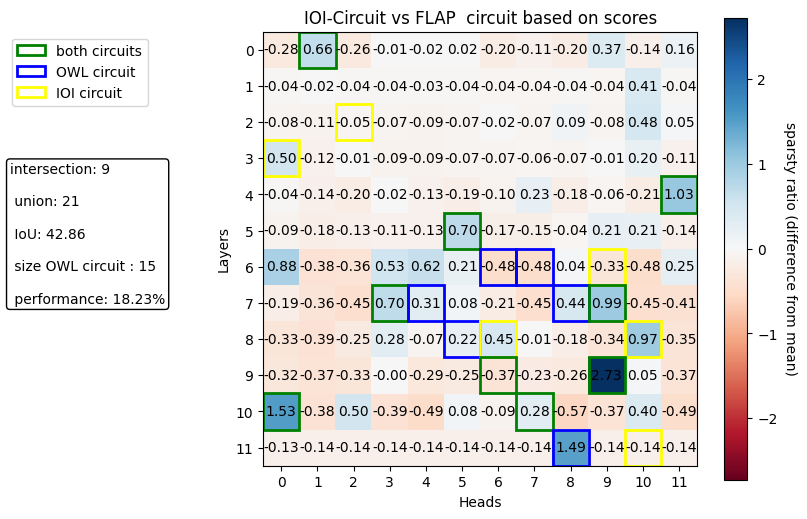

new_head {6: [6, 7], 7: [8, 4], 8: [5], 9: [6], 10: [7]}
outlier heads [(6, 0)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:02<00:00,  4.88it/s]

0


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.27it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



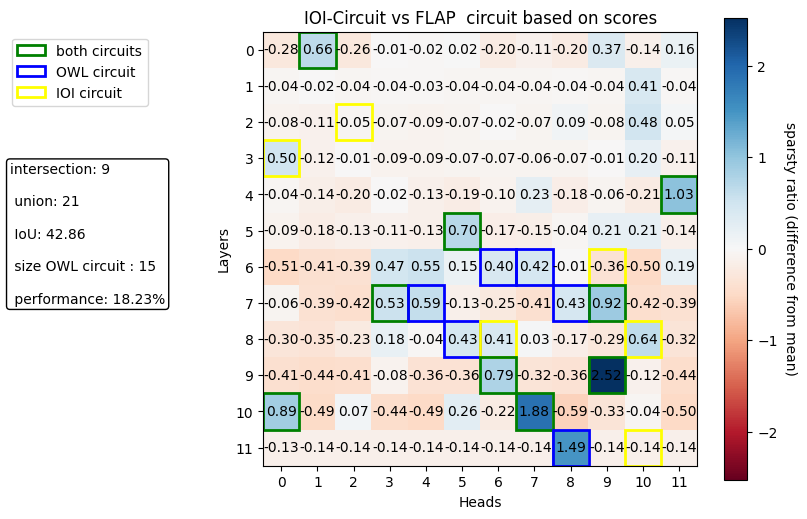

new_head {6: [6, 7], 7: [8], 8: [5]}
outlier heads [(6, 0), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  6.33it/s]

0
384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.04it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



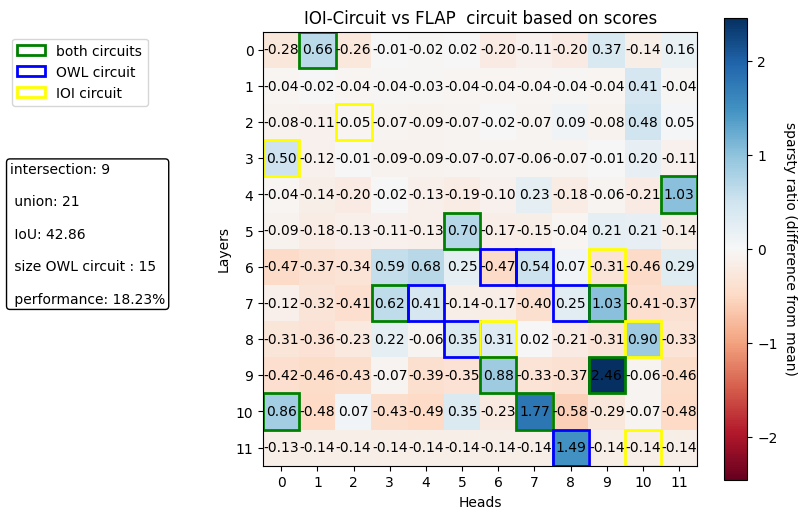

new_head {6: [6], 7: [8, 4], 8: [5]}
outlier heads [(6, 0), (6, 6), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  6.40it/s]

0
384
384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.14it/s]


*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



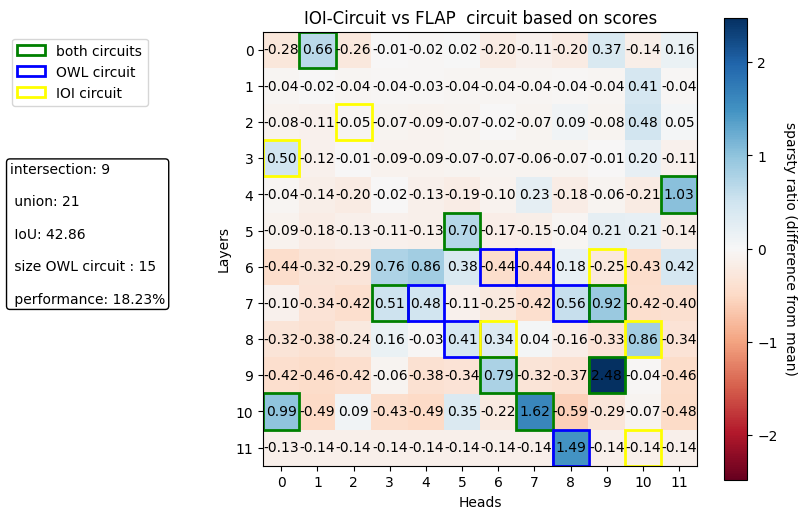

new_head {6: [6, 7], 7: [4], 8: [5]}


In [75]:

torch.cuda.empty_cache()
gc.collect()

device = args.device

if "llama" in args.model:
    # Llama Model
    model = get_Llama(args.model, args.cache_dir, device=device, use_4bit=args.use_4bit)
    tokenizer = LlamaTokenizer.from_pretrained(args.model, use_fast=False)
    tokenizer.eos_token_id = 0
    tokenizer.pad_token_id = 0

elif "gpt2" in args.model:
    # GPT2 Model
    model = get_gpt2_adapt("gpt2", "/mnt/lustre/work/eickhoff/esx670/llm_weights")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

device = torch.device(device)
model.to(device)
model.eval()

### 1) Run First FLAP 
# Prune the model
CIRCUIT, scores, fluctuation_scores, activation_scores, unstand_scores = prune_flap(args, model, tokenizer, device)

ave_logit_FLAP, performance_FLAP = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )
gain_FLAP = performance_gain(performance_new=performance_FLAP, performance_old=performance_IOI)

print_statics(
    title="*********** FLAP CIRCUIT vs IOI CIRCUIT **************",
    ave_logit=ave_logit_FLAP, 
    performance_achieved=performance_FLAP,
    CIRCUIT=CIRCUIT, 
    IOI_CIRCUIT=IOI_CIRCUIT,
    performance_gain=gain_FLAP
    )

heat_map_sparsity(
    scores, 
    IOI_CIRCUIT,
    CIRCUIT, 
    title=f"IOI-Circuit vs FLAP  circuit based on scores",
    performance=performance)

# 2) evaluate all nodes 
CIRCUIT_REMOVED =  copy.deepcopy(CIRCUIT)
results = pd.DataFrame(columns=["layer", "head", "logit", "performance", "gain"])


for layer, all_heads in CIRCUIT.items():
    # Remove a head from the FLAP circuit that is not present in the IOI circuit
    for head in all_heads: 
        CIRCUIT_REMOVED[layer].remove(head)

        ave_logit_REMOVED, performance_REMOVED = evaluate_circiut(
        model = model_mean_ablation, 
        CIRCUIT=CIRCUIT_REMOVED,
        dataset=dataset,
        ave_logit_gt=ave_logit_gt
        )

        gain_REMOVED = performance_gain(performance_new=performance_REMOVED, performance_old=performance_FLAP)
        print_statics(
            title=f"*********** REMOVE head {layer, head} **************",
            ave_logit=ave_logit_REMOVED, 
            performance_achieved=performance_REMOVED,
            CIRCUIT=CIRCUIT_REMOVED, 
            IOI_CIRCUIT=IOI_CIRCUIT,
            performance_gain=gain_REMOVED,
            circuit_type="FLAP-REMOVED"
            )
        # add head again
        
        new_col = pd.DataFrame({"layer": layer, "head": head, "logit":ave_logit_REMOVED, "performance":performance_REMOVED, "gain":gain_REMOVED}, index=[0])
        results = pd.concat([results, new_col], ignore_index=True)
        
        layer_heads = CIRCUIT_REMOVED[layer] 
        if not layer_heads is None:
            layer_heads.append(head)
        else:
            CIRCUIT_REMOVED[layer] = [head]

# 2) get the nodes with the lowest influence
t_results = torch.tensor(results.values.tolist())
idx = torch.sort(torch.abs(t_results[:, -1]), descending=False).indices[:4]

for i in idx:
    gain = float("-inf")
    stop = 0

    layer = int(t_results[i, 0].item())
    head = int(t_results[i, 1].item())
    outlier_heads = [(layer, head)]

    while  stop < 3:
        stop += 1
        print("outlier heads", outlier_heads)
        
        torch.cuda.empty_cache()
        gc.collect()
            
        model = get_gpt2_adapt("gpt2", "/mnt/lustre/work/eickhoff/esx670/llm_weights")
        model.to(device)
        model.eval()
        
        for layer, head in outlier_heads:
            model.model.layers[layer].self_attn.remove_head(head)
        
        CIRCUIT, scores, fluctuation_scores, activation_scores, unstand_scores = prune_flap(args, model, tokenizer, device, outlier_heads)
            
        ave_logit, performance = evaluate_circiut(
            model = model_mean_ablation, 
            CIRCUIT=NEW_CIRCUIT,
            dataset=dataset,
            ave_logit_gt=ave_logit_gt
            )
        gain = performance_gain(performance_new=performance, performance_old=performance_FLAP)

        print_statics(
            title="*********** FLAP CIRCUIT vs IOI CIRCUIT **************",
            ave_logit=ave_logit, 
            performance_achieved=performance,
            CIRCUIT=NEW_CIRCUIT, 
            IOI_CIRCUIT=IOI_CIRCUIT,
            performance_gain=gain
            )

        heat_map_sparsity(
            scores, 
            IOI_CIRCUIT,
            NEW_CIRCUIT, 
            title=f"IOI-Circuit vs FLAP  circuit based on scores",
            performance=performance)
        
        new_head = get_difference(NEW_CIRCUIT, CIRCUIT)
        print("new_head", new_head)
        outlier_heads.append((list(new_head.items())[0][0], list(new_head.items())[0][1][0]))

            

outlier heads [(11, 8)]


/mnt/lustre/work/eickhoff/esx670/.conda/py-311-pytorch_clone1/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


loading calibdation data
using different length!
dataset loading complete


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.58s/it]


512
*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



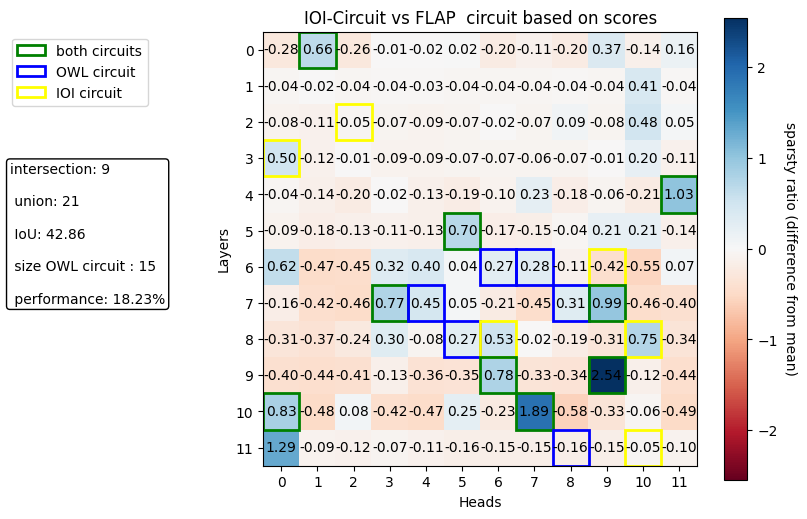

new_head {6: [6, 7], 7: [8, 4], 8: [5], 11: [8]}
outlier heads [(11, 8), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  6.23it/s]

384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.18it/s]


512
*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



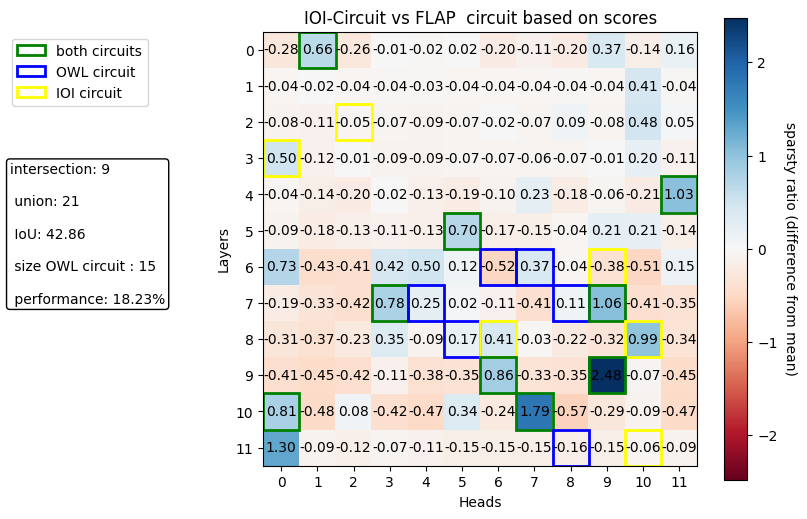

new_head {6: [6, 7], 7: [8, 4], 8: [5], 11: [8]}
outlier heads [(11, 8), (6, 6), (6, 6)]
loading calibdation data
using different length!
dataset loading complete


Processing layers:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8/12 [00:01<00:00,  5.89it/s]

384
384


Processing layers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.80it/s]


512
*********** FLAP CIRCUIT vs IOI CIRCUIT **************
Average logit difference (IOI dataset, ): 0.5524
circuit size 15
performance achieved 18.23%
IoU of IOI and CIRCUIT  42.86%
performance gain -68.20%



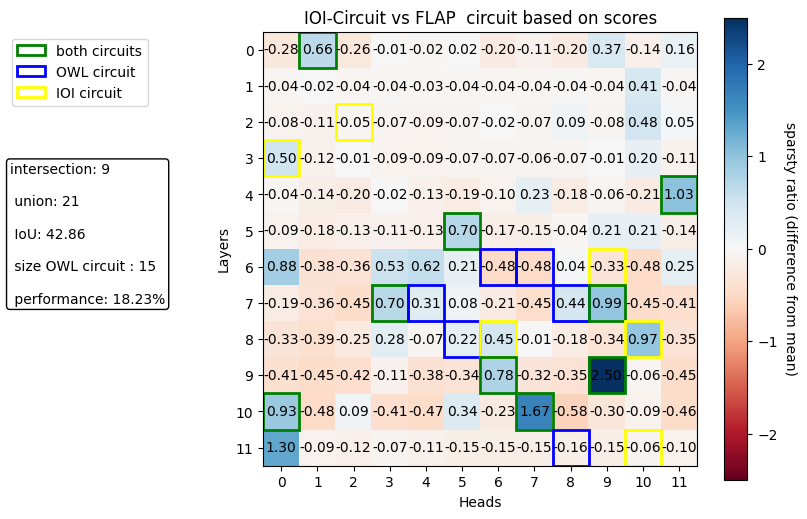

new_head {6: [6, 7], 7: [8, 4], 8: [5], 11: [8]}


In [77]:
i = 14
gain = float("-inf")
stop = 0

layer = int(t_results[i, 0].item())
head = int(t_results[i, 1].item())
outlier_heads = [(layer, head)]

while  stop < 3:
    stop += 1
    print("outlier heads", outlier_heads)
    
    torch.cuda.empty_cache()
    gc.collect()
        
    model = get_gpt2_adapt("gpt2", "/mnt/lustre/work/eickhoff/esx670/llm_weights")
    model.to(device)
    model.eval()
    
    for layer, head in outlier_heads:
        model.model.layers[layer].self_attn.remove_head(head)
    
    CIRCUIT, scores, fluctuation_scores, activation_scores, unstand_scores = prune_flap(args, model, tokenizer, device, outlier_heads)
        
    ave_logit, performance = evaluate_circiut(
        model = model_mean_ablation, 
        CIRCUIT=NEW_CIRCUIT,
        dataset=dataset,
        ave_logit_gt=ave_logit_gt
        )
    gain = performance_gain(performance_new=performance, performance_old=performance_FLAP)

    print_statics(
        title="*********** FLAP CIRCUIT vs IOI CIRCUIT **************",
        ave_logit=ave_logit, 
        performance_achieved=performance,
        CIRCUIT=NEW_CIRCUIT, 
        IOI_CIRCUIT=IOI_CIRCUIT,
        performance_gain=gain
        )

    heat_map_sparsity(
        scores, 
        IOI_CIRCUIT,
        NEW_CIRCUIT, 
        title=f"IOI-Circuit vs FLAP  circuit based on scores",
        performance=performance)
    
    new_head = get_difference(NEW_CIRCUIT, CIRCUIT)
    print("new_head", new_head)
    outlier_heads.append((list(new_head.items())[0][0], list(new_head.items())[0][1][0]))
        

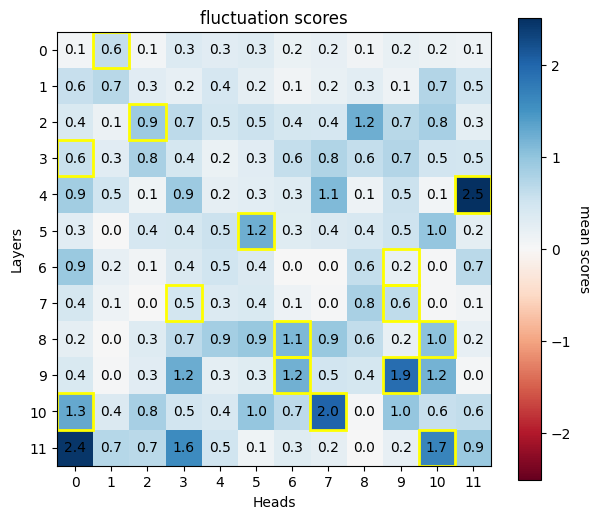

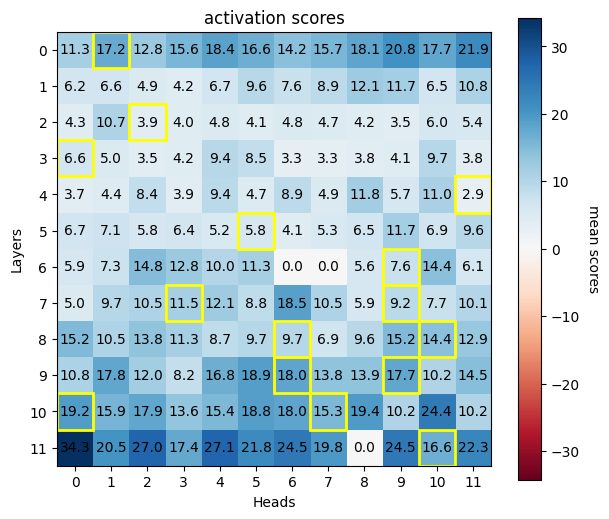

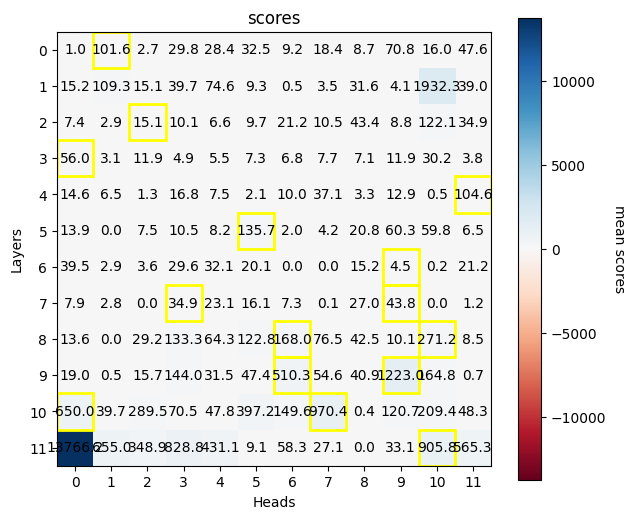

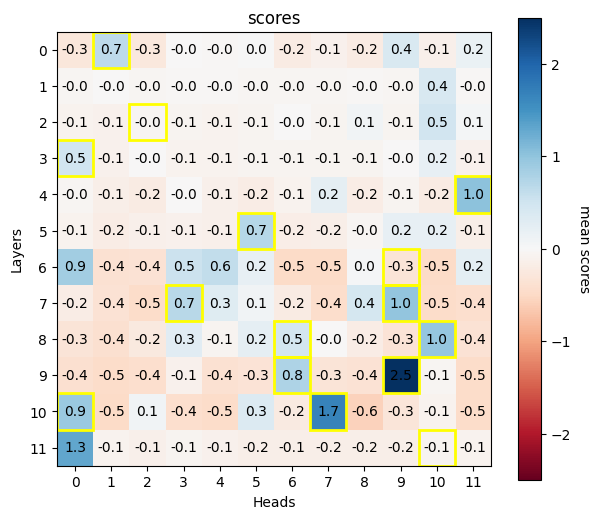

In [83]:
standarlization = lambda x: (x - torch.mean(x, axis=1, keepdim=True)) / torch.std(x, axis=1, keepdim=True)

from utils.Visualization import plot_scores
plot_scores(fluctuation_scores, IOI_CIRCUIT, title="fluctuation scores")
plot_scores(activation_scores, IOI_CIRCUIT, title="activation scores")
plot_scores(unstand_scores, IOI_CIRCUIT, title="scores")
plot_scores(scores, IOI_CIRCUIT, title="scores")